In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import h5py
import pystan
from true_params import true_params

/Users/wfarr/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/wfarr/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [17]:
fits = {}
for nsel in [32768, 65536, 131072]:
    fits[nsel] = az.from_netcdf('exact-{:d}.nc'.format(nsel))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1de75cc0>,
      dtype=object)

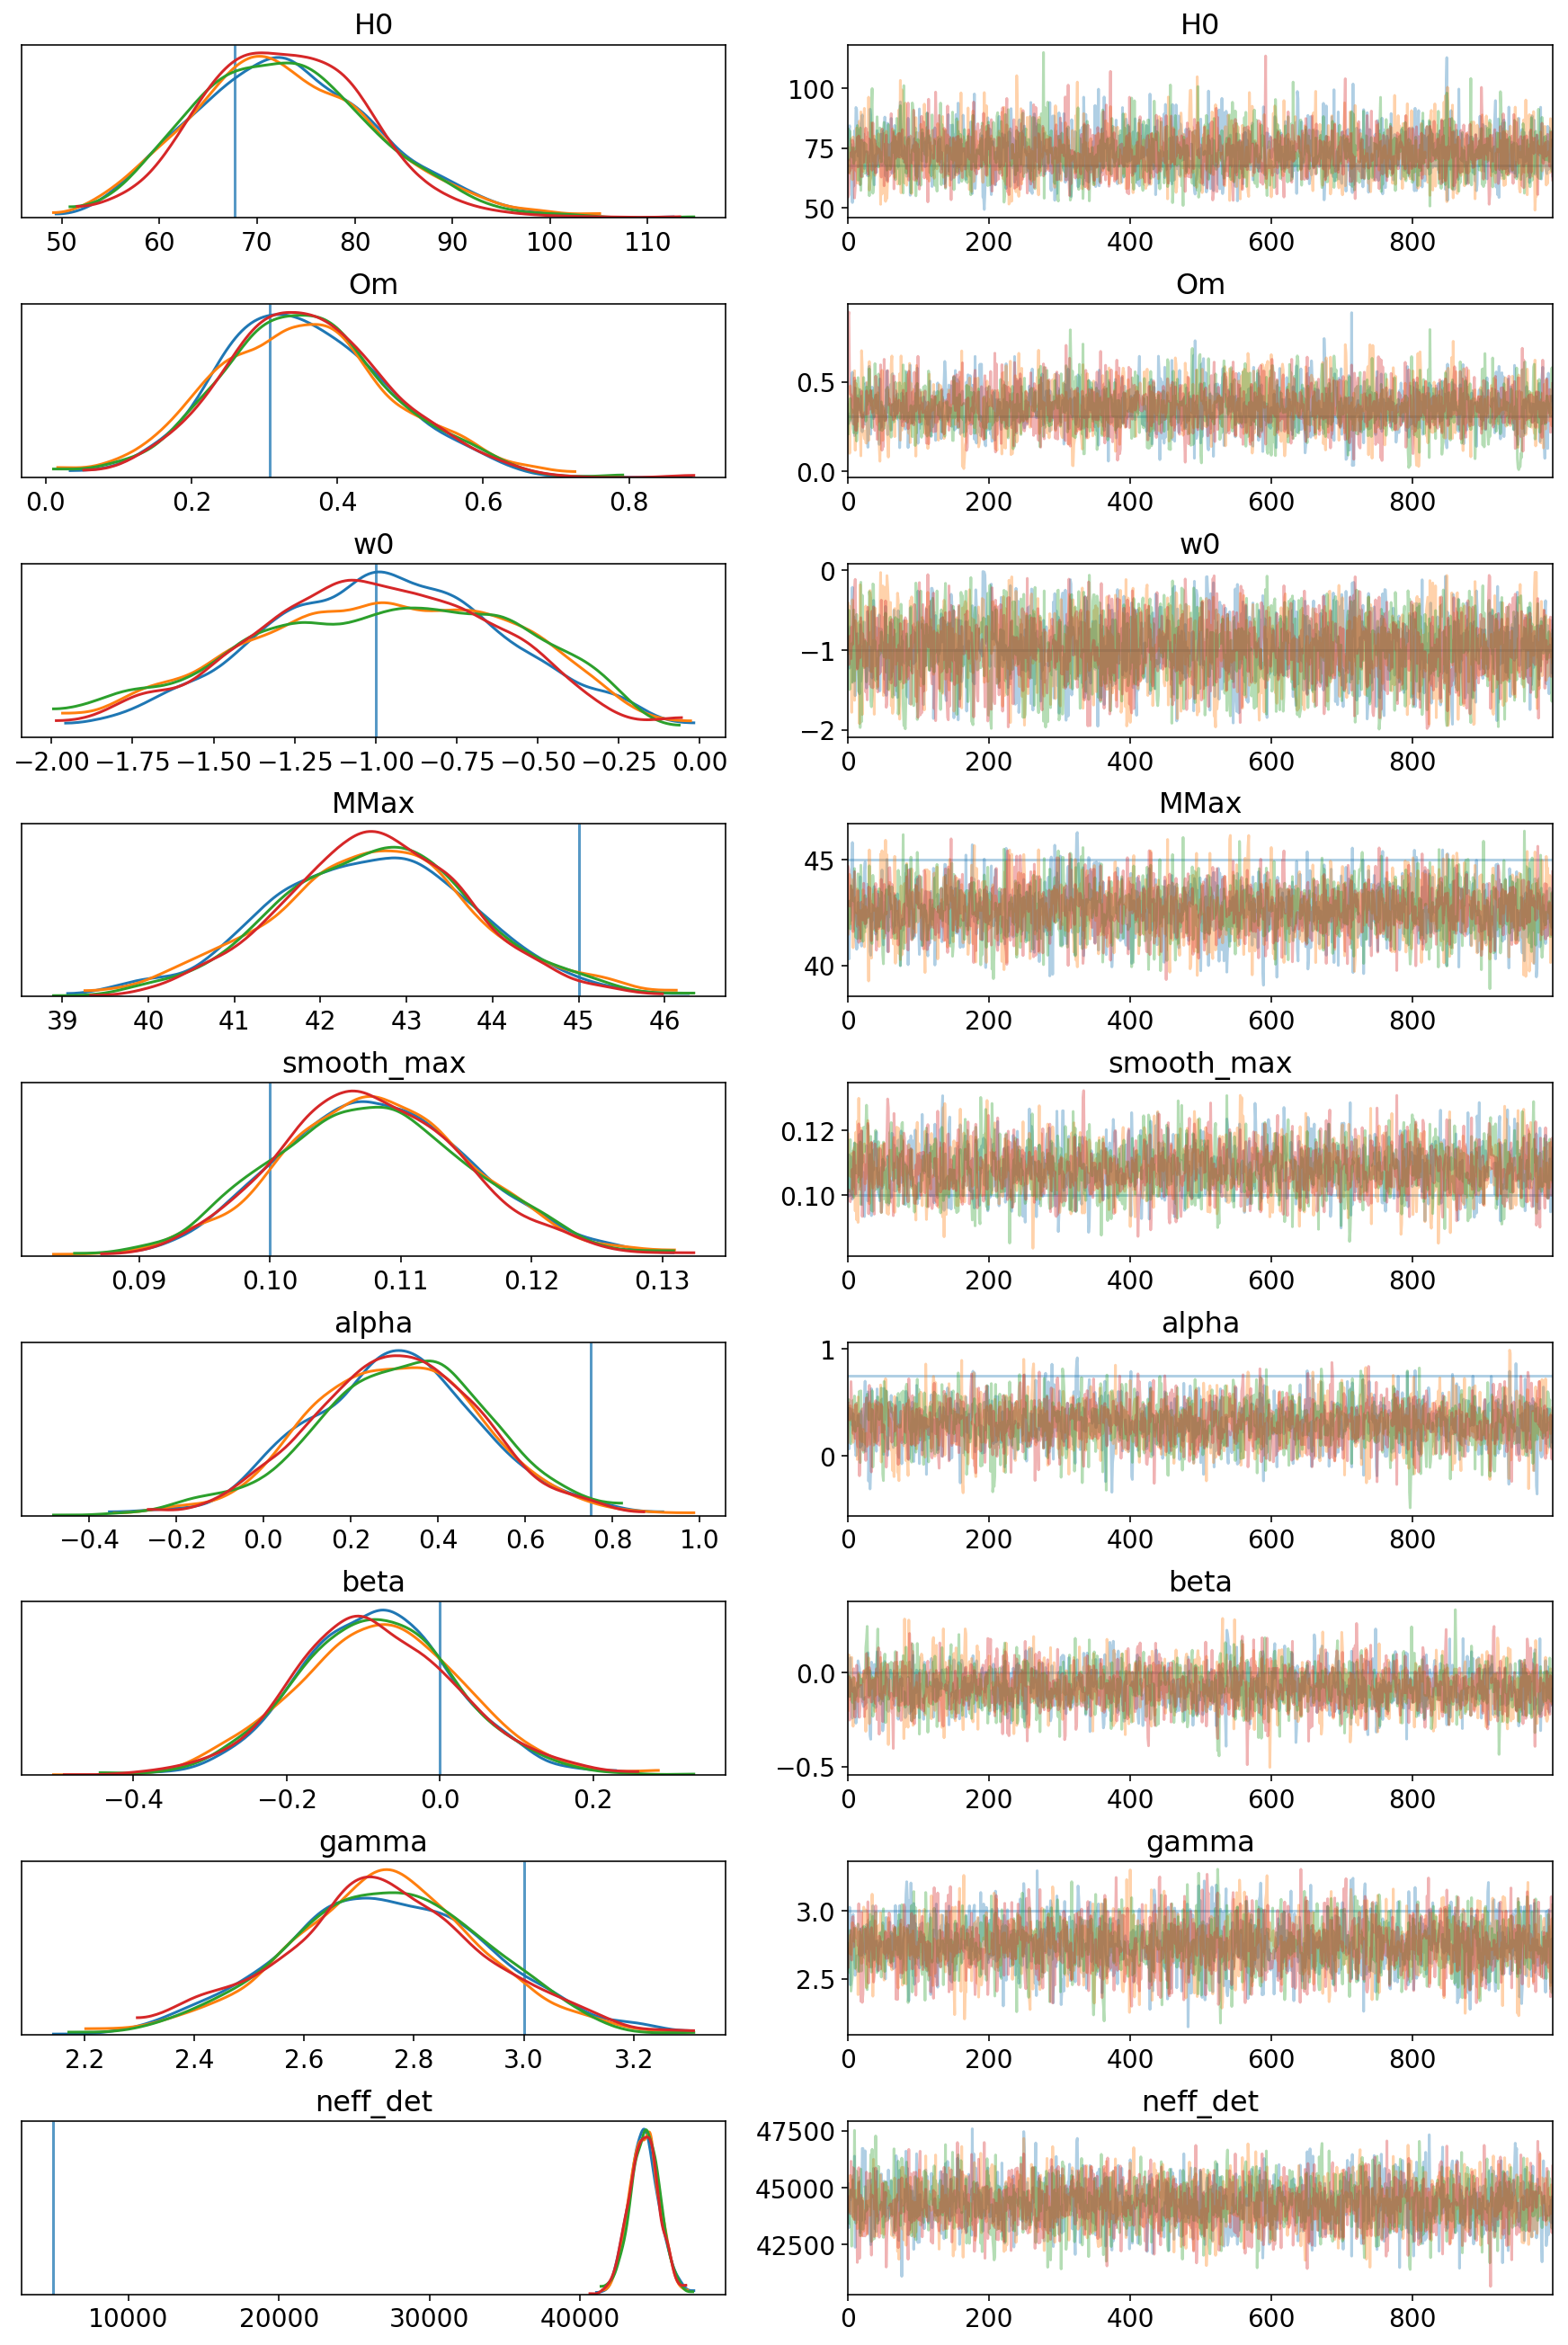

In [18]:
nobs = fits[32768].posterior.m1source.values.shape[2]
az.plot_trace(fits[131072], var_names=['H0', 'Om', 'w0', 'MMax', 'smooth_max', 'alpha', 'beta', 'gamma', 'neff_det'],
              lines=(('H0', {}, Planck15.H0.to(u.km/u.s/u.Mpc).value),
                     ('Om', {}, Planck15.Om0),
                     ('w0', {}, -1),
                     ('MMax', {}, true_params['MMax']),
                     ('smooth_max', {}, true_params['smooth_max']),
                     ('alpha', {}, true_params['alpha']),
                     ('beta', {}, true_params['beta']),
                     ('gamma', {}, true_params['gamma']),
                     ('neff_det', {}, 5*nobs))) # Ensure we are safe for selection effects

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c25ab9e10>,
      dtype=object)

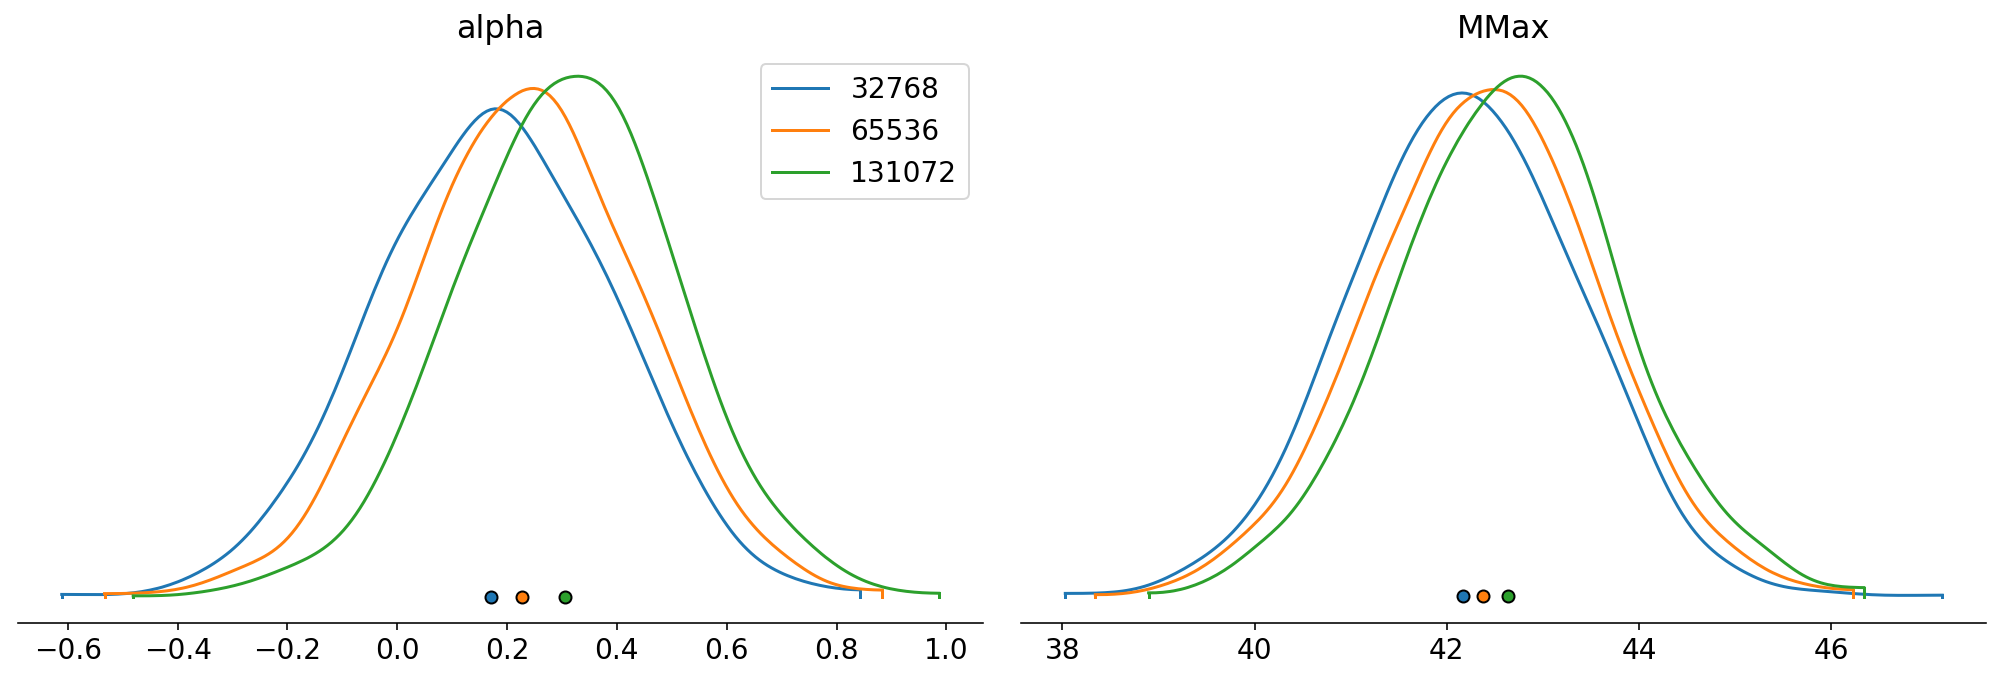

In [19]:
fs = list(fits.values())
ls = list(map(str, fits.keys()))
az.plot_density(fs, var_names=['alpha', 'MMax'], data_labels=ls, credible_interval=1)